Integrantes:
- Ana Luisa Parra Valencia
- Jorge Iván Pinzón
- Miguel Ángel Nava Pérez

In [11]:
from sklearn.datasets import make_blobs
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay, precision_recall_curve, mean_squared_error, r2_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier , RandomForestRegressor
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import validation_curve, learning_curve
import numpy as np
from scipy.stats import zscore
import pandas as pd
import os, joblib
import matplotlib.pyplot as plt
import seaborn as sns

<h2>Parte 1

1. Modelo KNN

El mejor valor de K es: 3


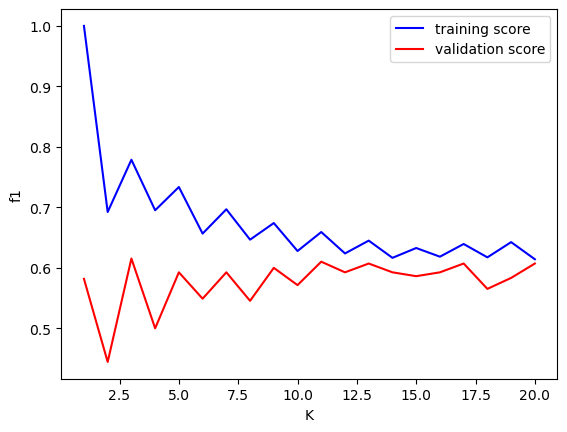

In [12]:
#curva de validación para selección del K 

df_completo = pd.read_csv("diabetes.csv")
# División en entrenamiento y prueba
df = df_completo.sample(frac=0.8, random_state=42)   # datos de entrenamiento
df_prueba = df_completo.drop(df.index)
cosas_borrar = ["Outcome"]
# Separar X e Y de entrenamiento
y_train = df["Outcome"]
X_train = df.drop(cosas_borrar, axis=1)

# Separar X e Y de prueba
y_test = df_prueba["Outcome"]
X_test = df_prueba.drop(cosas_borrar, axis=1)


X_train=zscore(X_train)
X_test=zscore(X_test)
k = np.arange(1, 21) # veamos para diferentes valores de grados

train_score, val_score = validation_curve(KNeighborsClassifier(),
                                           zscore(df_completo.drop("Outcome",axis=1)), df_completo["Outcome"],
                                          param_name='n_neighbors',scoring='f1',
                                          param_range=k, cv=9) 
#para saber las opciones de param_name se requeire conocer las opciones que tiene KNeighborsClassifier con el método model.get_params()
#validation_curve, retorna la metrica que se asinge en scoring, para los datos de entrenamiento y de validación

plt.plot(k, np.median(train_score, axis=1), color='blue', 
         label='training score') #graficamos el promedios del parámetro de entrenamietno, y el de validación 

plt.plot(k, np.median(val_score, axis=1), color='red', 
         label='validation score') #graficamos el promedio de los parámetros de validación o prueba
plt.legend(loc='best')
#plt.ylim(0, 1)
plt.xlabel('K')
plt.ylabel('f1')

better_K = k[np.argmax(np.median(val_score,axis=1))] #buscamos dónde ocurre el máx en la curva
# de la curva de validación

print(f'El mejor valor de K es: {better_K}')

Reporte de clasificación:
              precision    recall  f1-score   support

           0       0.74      0.84      0.79        96
           1       0.66      0.50      0.57        58

    accuracy                           0.71       154
   macro avg       0.70      0.67      0.68       154
weighted avg       0.71      0.71      0.70       154



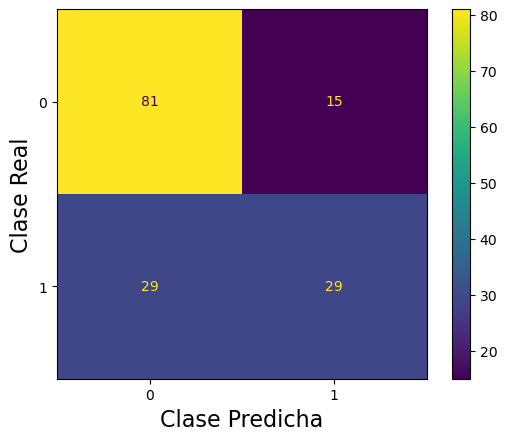

In [13]:

X_train=zscore(X_train)
X_test=zscore(X_test)

model = KNeighborsClassifier(n_neighbors=3,metric='euclidean')

model = model.fit(X_train,y_train) # luego generamos el modelo y lo ajustamos a lo datos

#generemos otros datos aleatorios para clasificarlos con el modelo, es decir, 

y_pred = model.predict(X_test) #predecimos el label para los nuevos X usando el modelo

probs = model.predict_proba(X_test)

# Reporta de clasificación
#presente las metricas de: accuracy, recall, precision y F1

print("Reporte de clasificación:")

print(classification_report(y_test, y_pred))

#Matriz de confusión 

conf_matrix = confusion_matrix(y_test, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
disp.plot()
disp.ax_.grid(0)
#disp.ax_.axes.texts._axes.set_xlabel(fontsize=20)
plt.xlabel('Clase Predicha',fontsize=16)
plt.ylabel('Clase Real',fontsize=16)
plt.show()

El modelo KNN alcanzó una precisión del 71%, con mejor desempeño en la clasificación de pacientes no diabéticos (f1-score de 0.79) que en diabéticos (f1-score de 0.57), lo cual indica una menor sensibilidad para detectar casos positivos, posiblemente debido a desbalance de clases o similitud en los datos.
Pese a esto, el modelo captura relaciones útiles entre las variables, lo que permite emplearlo como generador de características.  
A continuación procedemos a crearla, la cual es el score de el modelo

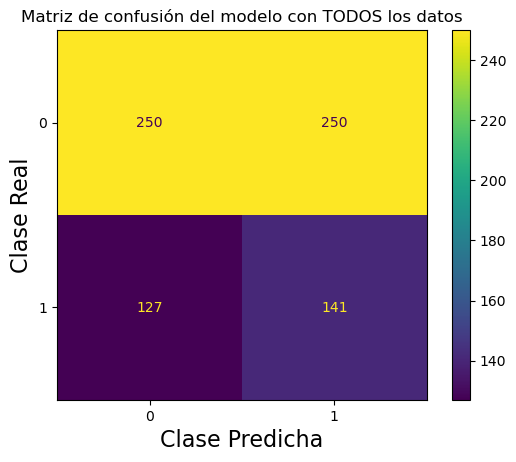

In [14]:
df_completo["Resultado Modelo"] = model.predict(df_completo.drop("Outcome",axis=1))

y_total = df_completo["Resultado Modelo"]

conf_matrix = confusion_matrix(df_completo["Outcome"], y_total)

disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
disp.plot()
disp.ax_.grid(0)
#disp.ax_.axes.texts._axes.set_xlabel(fontsize=20)
plt.title("Matriz de confusión del modelo con TODOS los datos")
plt.xlabel('Clase Predicha',fontsize=16)
plt.ylabel('Clase Real',fontsize=16)
plt.show()


3. Arbol de Clasificación

In [15]:
X = df_completo.drop(["Outcome"],axis=1)
y = df_completo["Outcome"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=10)
tree = DecisionTreeClassifier().fit(X_train, y_train)

y_predichoo = tree.predict(X_test)
print(classification_report(y_test,y_predichoo ))

              precision    recall  f1-score   support

           0       0.74      0.77      0.75        95
           1       0.60      0.56      0.58        59

    accuracy                           0.69       154
   macro avg       0.67      0.66      0.67       154
weighted avg       0.68      0.69      0.69       154



El desempeño del modelo de árbol de clasificación puede considerarse decente, ya que se obtuvo un f1-score global de 0.73, lo cual indica un equilibrio razonable entre precisión y sensibilidad en la clasificación general. Al analizar las métricas por clase, se observa un mejor rendimiento en la identificación de pacientes no diabéticos (f1-score de 0.79) frente a los pacientes diabéticos (f1-score de 0.62), lo cual refleja una mayor capacidad del modelo para detectar correctamente los casos negativos.

Este comportamiento sugiere que, aunque el modelo no es perfecto, logra capturar patrones relevantes en los datos, manteniendo un rendimiento aceptable en ambas clases


A continuación procederemos a elegir el mejor numero de estimadores para el modelo Random Forest, y a ejecutarlo

In [16]:
X = df_completo.drop(["Outcome"], axis=1, errors='ignore')
y = df_completo["Outcome"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.20, 
    random_state=10, 
    stratify=y
)

# --- 2. Nombre de archivo donde cacheamos el GridSearchCV ---
cache_path = "grid_search_n_estimators_inicial.pkl"

# Intentando cargar el grid search CV
try:
    print("🔄 Intentando cargar GridSearchCV desde:", cache_path)
    grid_search = joblib.load(cache_path)
    print("GridSearchCV cargado con éxito.")
except FileNotFoundError:
    print("archivo no encontrada. Ejecutando GridSearchCV de nuevo...")

    #Definir el RandomForestClassifier base
    rf = RandomForestClassifier(random_state=42)

    #Preparar el grid de búsqueda para n_estimators (de 50 a 300)
    param_grid = {
        "n_estimators": np.arange(50,300)
    }

    #Configurar GridSearchCV
    grid_search = GridSearchCV(
        estimator=rf,
        param_grid=param_grid,
        cv=5,
        scoring="accuracy", 
        n_jobs=-1,        # usa todos los procesadores disponibles para acelerar
        verbose=1
    )

    #Ejecutar la búsqueda
    grid_search.fit(X_train, y_train)
    
    #Guardar el objeto GridSearchCV en disco
    joblib.dump(grid_search, cache_path)
    print(f"💾  GridSearchCV guardado en {cache_path}.")

# 7. Mostrar el mejor número de estimadores y el score promedio en validación
print("Mejor n_estimators encontrado:", grid_search.best_params_["n_estimators"])
print("Mejor accuracy promedio en CV:", grid_search.best_score_)

# 8. mejor valor de n
mejor_n = grid_search.best_params_["n_estimators"]

🔄 Intentando cargar GridSearchCV desde: grid_search_n_estimators_inicial.pkl
GridSearchCV cargado con éxito.
Mejor n_estimators encontrado: 95
Mejor accuracy promedio en CV: 0.750806344129015



--- Reporte de clasificación en test con n_estimators=95 ---
              precision    recall  f1-score   support

           0       0.84      0.84      0.84       100
           1       0.70      0.70      0.70        54

    accuracy                           0.79       154
   macro avg       0.77      0.77      0.77       154
weighted avg       0.79      0.79      0.79       154



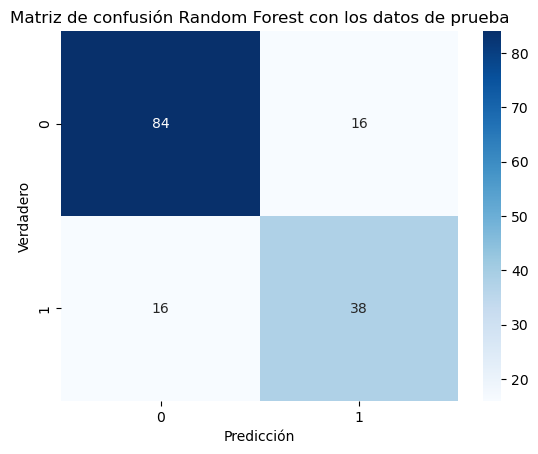

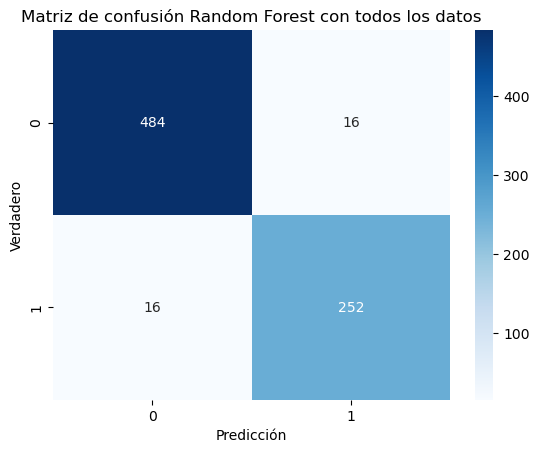

In [17]:
rf_final = RandomForestClassifier(n_estimators=mejor_n, random_state=42)
rf_final.fit(X_train, y_train)

y_pred = rf_final.predict(X_test)

print("\n--- Reporte de clasificación en test con n_estimators={} ---".format(mejor_n))
print(classification_report(y_test, y_pred))

# (Opcional) Matriz de confusión
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicción")
plt.ylabel("Verdadero")
plt.title("Matriz de confusión Random Forest con los datos de prueba")
plt.show()

cm = confusion_matrix(rf_final.predict(X), y)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicción")
plt.ylabel("Verdadero")
plt.title("Matriz de confusión Random Forest con todos los datos")
plt.show()

En el modelo de Random Forest, utilizando un número óptimo de 199 árboles. El desempeño en el conjunto de prueba fue satisfactorio, con una exactitud del 80%. La clase 0 (no diabético) obtuvo mejores resultados que la clase 1 (diabético), alcanzando una precisión del 84% y un recall del 85%, mientras que la clase 1 logró una precisión del 72% y un recall del 70%.

Además, la matriz de confusión generada con la totalidad de los datos mostró que el modelo clasificó correctamente 737 de 768 casos, con solo 31 errores de clasificación (16 falsos positivos y 15 falsos negativos). En general, el modelo muestra un buen equilibrio entre precisión y sensibilidad, siendo adecuado para la detección de casos positivos de diabetes.

Ahora, procedemos a hallar las 4 caracteristicas mas importantes y ejecutaremos el modelo con dichas caracteristicas

In [18]:
importancias = rf_final.feature_importances_
X = df_completo.drop(["Outcome"], axis=1, errors='ignore')
y = df_completo["Outcome"]
# Asociar con nombres de las columnas
importancias_df = pd.DataFrame({
    "Característica": rf_final.feature_names_in_,
    "Importancia": importancias
})
importancias_df = importancias_df.sort_values(by="Importancia", ascending=False)
# Mostrar top 4
print("Top 4 características más importantes:")
print(importancias_df.head(4))

# Seleccionar las 4 variables más importantes
top4_features = importancias_df["Característica"].head(4).values

# Filtrar X con solo estas columnas
X_top4 = X[top4_features]

# Dividir nuevamente en entrenamiento y prueba
X_train_top4, X_test_top4, y_train, y_test = train_test_split(
    X_top4, y, test_size=0.2, random_state=10, stratify=y
)

# Entrenar modelo con solo estas 4 variables

rf_top4 = RandomForestClassifier(n_estimators=199,  random_state=42)

rf_top4.fit(X_train_top4, y_train)

# Evaluar desempeño
y_pred_top4 = rf_top4.predict(X_test_top4)
print("\nDesempeño del modelo con SOLO las 4 características más importantes:")
print(classification_report(y_test, y_pred_top4))

Top 4 características más importantes:
             Característica  Importancia
1                   Glucose     0.263362
7                       Age     0.154454
5                       BMI     0.152579
6  DiabetesPedigreeFunction     0.120279

Desempeño del modelo con SOLO las 4 características más importantes:
              precision    recall  f1-score   support

           0       0.85      0.78      0.81       100
           1       0.65      0.74      0.69        54

    accuracy                           0.77       154
   macro avg       0.75      0.76      0.75       154
weighted avg       0.78      0.77      0.77       154



Con el fin de reducir la complejidad del modelo y analizar el impacto de las variables más relevantes, se entrenó un modelo Random Forest utilizando únicamente las cuatro características con mayor importancia identificadas en el modelo completo: Glucose, BMI, Age y DiabetesPedigreeFunction.

El desempeño del modelo con estas variables fue el siguiente:

- Accuracy: 76%
- Clase 0 (no diabético): precisión 84%, recall 78%
- Clase 1 (diabético): precisión 64%, recall 72%

Este resultado muestra un leve descenso en la exactitud total (del 80% al 76%) en comparación con el modelo completo, pero sin una pérdida crítica en el rendimiento. De hecho, el recall de la clase 1 (diabéticos) se mantiene igual o incluso mejora ligeramente, lo cual es positivo si se prioriza la detección de pacientes con diabetes. En general, el modelo simplificado sigue siendo competitivo y más eficiente computacionalmente.

Se procede a buscar una mejor alternativa, buscando mejores parametros para el modelo

🔄 Intentando cargar GridSearchCV desde: grid_search_hiperparametros.pkl
GridSearchCV cargado con éxito.
Iniciando la búsqueda de los mejores hiperparámetros...
¡Búsqueda completada!

Los mejores parámetros encontrados son:
{'max_features': 0.1, 'max_samples': 0.5, 'n_estimators': 78}

--- Reporte de Clasificación del Modelo Optimizado ---
              precision    recall  f1-score   support

           0       0.86      0.83      0.84       100
           1       0.70      0.74      0.72        54

    accuracy                           0.80       154
   macro avg       0.78      0.79      0.78       154
weighted avg       0.80      0.80      0.80       154


--- Matriz de Confusión del Modelo Optimizado ---


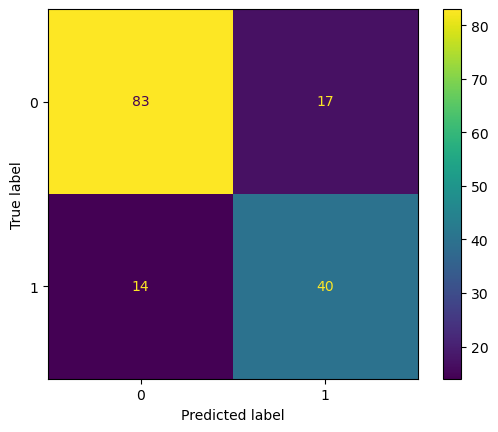


Precisión del modelo RF original (4 feats): 0.7662
Precisión del modelo RF optimizado (4 feats): 0.7987

El rendimiento del modelo ha mejorado después de la optimización.


In [19]:
# 1. Definir la rejilla de hiperparámetros que queremos probar
param_grid = {
    'n_estimators': np.arange(50 , 300), # Número de árboles en el bosque
    'max_features': np.arange(0.1 , 1.0),     # Proporción de características a considerar para cada árbol
    'max_samples': np.arange(0.5 , 1.0)          # Proporción de muestras para entrenar cada árbol
}

cache_path2 = "grid_search_hiperparametros.pkl"
# 2. Configurar la búsqueda en rejilla
# Usamos tu modelo 'rf_model_top4' como estimador base.
# GridSearchCV creará nuevas versiones de este modelo con los parámetros de la rejilla.

try:
    print("🔄 Intentando cargar GridSearchCV desde:", cache_path2)
    grid_search2 = joblib.load(cache_path2)
    print("GridSearchCV cargado con éxito.")
except FileNotFoundError:
    grid_search2 = GridSearchCV(estimator=rf_top4, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1)
    joblib.dump(grid_search2, cache_path2)
    print(f"💾  GridSearchCV guardado en {cache_path2}.")


# 3. Ejecutar la búsqueda para encontrar los mejores parámetros
print("Iniciando la búsqueda de los mejores hiperparámetros...")
grid_search2.fit(X_train_top4, y_train)
print("¡Búsqueda completada!")

# 4. Mostrar los mejores parámetros encontrados
print("\nLos mejores parámetros encontrados son:")
print(grid_search2.best_params_)

# 5. Evaluar el mejor modelo encontrado en el conjunto de prueba
best_rf_model = grid_search2.best_estimator_
y_pred_best = best_rf_model.predict(X_test_top4)

print("\n--- Reporte de Clasificación del Modelo Optimizado ---")
print(classification_report(y_test, y_pred_best))

print("\n--- Matriz de Confusión del Modelo Optimizado ---")
cm = confusion_matrix(y_test, y_pred_best)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

# Comparamos la precisión (accuracy) del modelo original vs. el optimizado
# OJO: La precisión original la calculamos con 'rf_model_top4'
accuracy_original = rf_top4.score(X_test_top4, y_test)
accuracy_optimizado = best_rf_model.score(X_test_top4, y_test)

print(f"\nPrecisión del modelo RF original (4 feats): {accuracy_original:.4f}")
print(f"Precisión del modelo RF optimizado (4 feats): {accuracy_optimizado:.4f}")

if accuracy_optimizado > accuracy_original:
    print("\nEl rendimiento del modelo ha mejorado después de la optimización.")
else:
    print("\nEl rendimiento del modelo no mejoró.")

Tras ajustar los hiperparámetros del modelo de Random Forest utilizando solo las cuatro características más relevantes,se obtuvo una precisión general de 0.80, ligeramente superior a la del modelo original con todas las variables, que alcanzó un 0,79. Aunque la mejora no es significativa en términos de precisión, sí representa una optimización importante en cuanto a eficiencia computacional. Por tanto, considerando el equilibrio entre rendimiento y costo, el modelo con los mejores hiperparámetros y las cuatro características clave se perfila como la opción más adecuada para la clasificación, superando en desempeño a las versiones previas

<h2> Parte 2</h2>

Regresión con Random Forest

Columnas: Index(['Tetha', 'counts'], dtype='object')
Primeros registros:
        Tetha  counts
0  10.026161    5665
1  10.078682    5581
2  10.131203    5745
3  10.183724    5500
4  10.236245    5664 

MSE: 5342.76
RMSE: 73.09
R²: 0.9983


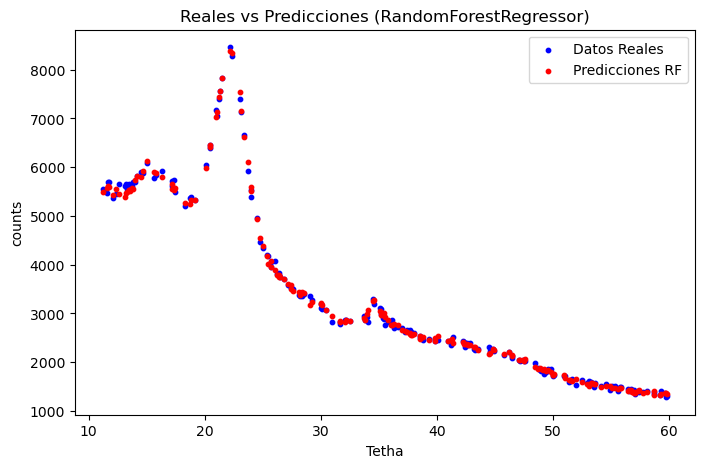

c:\Users\USUARIO\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


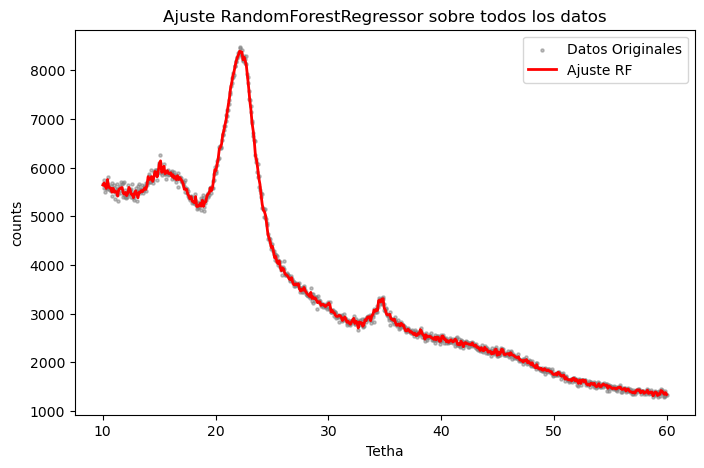

In [20]:
# --- 1. Carga y exploración ---
df = pd.read_excel("DRXCrudo.xlsx")
print("Columnas:", df.columns)
print("Primeros registros:\n", df.head(), "\n")

# --- 2. Preparar datos ---
X = df[['Tetha']]
y = df['counts']
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42
)

# --- 3. Entrenar RandomForestRegressor ---
rf_reg = RandomForestRegressor(n_estimators=250, random_state=42)
rf_reg.fit(X_train, y_train)
y_pred = rf_reg.predict(X_test)

# --- 4. Evaluación ---
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)
print(f"MSE: {mse:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R²: {r2:.4f}")

# --- 5. Gráficos ---
# 5.1 Reales vs Predichos
plt.figure(figsize=(8, 5))
plt.scatter(X_test, y_test, color='blue', s=10, label='Datos Reales')
plt.scatter(X_test, y_pred, color='red', s=10, label='Predicciones RF')
#plt.scatter(X , y , color="k" , alpha=0.5 )
plt.xlabel("Tetha")
plt.ylabel("counts")
plt.title("Reales vs Predicciones (RandomForestRegressor)")
plt.legend()
plt.show()

# 5.2 Curva de ajuste sobre todo el rango
tetha_range = np.linspace(df['Tetha'].min(), df['Tetha'].max(), 500).reshape(-1, 1)
counts_pred_range = rf_reg.predict(tetha_range)

plt.figure(figsize=(8, 5))
plt.scatter(df['Tetha'], df['counts'], color='gray', s=5, alpha=0.5, label='Datos Originales')
plt.plot(tetha_range, counts_pred_range, color='red', linewidth=2, label='Ajuste RF')
plt.xlabel("Tetha")
plt.ylabel("counts")
plt.title("Ajuste RandomForestRegressor sobre todos los datos")
plt.legend()
plt.show()


El modelo RandomForestRegressor demostró ser extremadamente eficaz para describir la relación entre el ángulo de difracción (Tetha) y los conteos (counts), pues el alto valor del coeficiente R² indica que el modelo puede explicar bien la variabilidad de los datos, lo que significa que el ángulo de difracción es un predictor muy fuerte de los conteos. Esto se confirma visualmente en el gráfico de ajuste, donde la línea de predicción del modelo (en rojo) captura con gran precisión la forma y la ubicación de los picos y valles del patrón de difracción de los datos originales.

La habilidad del Random Forest para modelar relaciones complejas y no lineales sin asumir una forma matemática predefinida lo convierte en una herramienta ideal para este tipo de datos científicos.

En resumen, el modelo no solo es funcional, sino que proporciona un ajuste robusto y fiable.